**Autoencoders**

In [ ]:
import sklearn

In [ ]:
import tensorflow as tf
from keras.utils import plot_model

In [ ]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

And let's create the `images/generative` folder (if it doesn't already exist), and define the `save_fig()` function which is used through this notebook to save the figures in high-res for the book:

In [ ]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "generative"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [ ]:
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if "google.colab" in sys.modules:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if "kaggle_secrets" in sys.modules:
        print("Go to Settings > Accelerator and select GPU.")

# Performing PCA with an Undercomplete Linear Autoencoder

Let's build the Autoencoder...

In [ ]:
import tensorflow as tf

tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

encoder = tf.keras.Sequential([tf.keras.layers.Dense(2)])
decoder = tf.keras.Sequential([tf.keras.layers.Dense(3)])
autoencoder = tf.keras.Sequential([encoder, decoder])

optimizer = tf.keras.optimizers.SGD(learning_rate=0.5)
autoencoder.compile(loss="mse", optimizer=optimizer)

Now let's generate the same 3D dataset:

In [ ]:
# extra code – builds the  3D dataset

import numpy as np
from scipy.spatial.transform import Rotation

m = 60
X = np.zeros((m, 3))  # initialize 3D dataset
np.random.seed(42)
angles = (np.random.rand(m) ** 3 + 0.5) * 2 * np.pi  # uneven distribution
X[:, 0], X[:, 1] = np.cos(angles), np.sin(angles) * 0.5  # oval
X += 0.28 * np.random.randn(m, 3)  # add more noise
X = Rotation.from_rotvec([np.pi / 29, -np.pi / 20, np.pi / 4]).apply(X)
X_train = X + [0.2, 0, 0.2]  # shift a bit

In [ ]:
history = autoencoder.fit(X_train, X_train, epochs=500, verbose=False)
codings = encoder.predict(X_train)

2/2 [==============================] - 0s 4ms/step


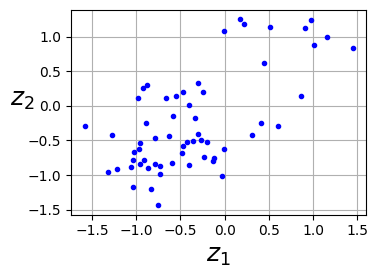

In [ ]:
fig = plt.figure(figsize=(4,3))
plt.plot(codings[:,0], codings[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)
save_fig("linear_autoencoder_pca_plot")
plt.show()

# Stacked Autoencoders

## Implementing a Stacked Autoencoder Using Keras

Let's load the fashion MNIST dataset, scale it, and split it into a training set, a validation set, and a test set:

In [ ]:
# extra code – loads, scales, and splits the fashion MNIST dataset
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

4422102/4422102 [==============================] - 0s 0us/step


Let's build and train a stacked Autoencoder with 3 hidden layers and 1 output layer (i.e., 2 stacked Autoencoders).

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

stacked_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(30, activation="relu"),
])
stacked_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28, 28])
])
stacked_ae = tf.keras.Sequential([stacked_encoder, stacked_decoder])

stacked_ae.compile(loss="mse", optimizer="nadam")
history = stacked_ae.fit(X_train, X_train, epochs=20,
                         validation_data=(X_valid, X_valid))

Epoch 1/20
1719/1719 [==============================] - 12s 4ms/step - loss: 0.0240 - val_loss: 0.0187
Epoch 2/20
1719/1719 [==============================] - 8s 5ms/step - loss: 0.0178 - val_loss: 0.0172
Epoch 3/20
1719/1719 [==============================] - 8s 5ms/step - loss: 0.0167 - val_loss: 0.0164
Epoch 4/20
1719/1719 [==============================] - 9s 5ms/step - loss: 0.0160 - val_loss: 0.0158
Epoch 5/20
1719/1719 [==============================] - 8s 5ms/step - loss: 0.0155 - val_loss: 0.0155
Epoch 6/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0152 - val_loss: 0.0152
Epoch 7/20
1719/1719 [==============================] - 8s 5ms/step - loss: 0.0150 - val_loss: 0.0152
Epoch 8/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0148 - val_loss: 0.0149
Epoch 9/20
1719/1719 [==============================] - 9s 5ms/step - loss: 0.0146 - val_loss: 0.0148
Epoch 10/20
1719/1719 [==============================] - 8s 4ms/step - loss: 0.01

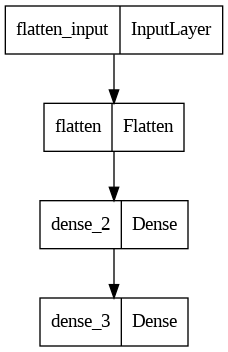

In [ ]:
plot_model(stacked_encoder)

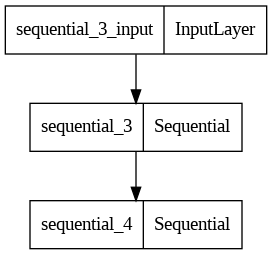

In [ ]:
plot_model(stacked_ae)

## Visualizing the Reconstructions

This function processes a few validation images through the autoencoder and displays the original images and their reconstructions:

1/1 [==============================] - 0s 66ms/step


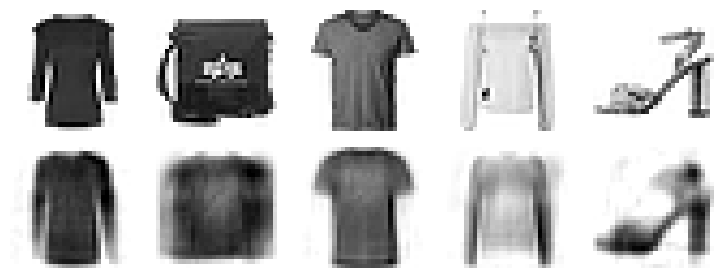

In [ ]:
import numpy as np

def plot_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = np.clip(model.predict(images[:n_images]), 0, 1)
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plt.imshow(images[image_index], cmap="binary")
        plt.axis("off")
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plt.imshow(reconstructions[image_index], cmap="binary")
        plt.axis("off")

plot_reconstructions(stacked_ae)
save_fig("reconstruction_plot")  # extra code – saves the high res figure
plt.show()

The reconstructions look fuzzy, but remember that the images were compressed down to just 30 numbers, instead of 784.

## Visualizing the Fashion MNIST Dataset

In [ ]:
from sklearn.manifold import TSNE

X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE(init="pca", learning_rate="auto", random_state=42)
X_valid_2D = tsne.fit_transform(X_valid_compressed)

157/157 [==============================] - 0s 2ms/step


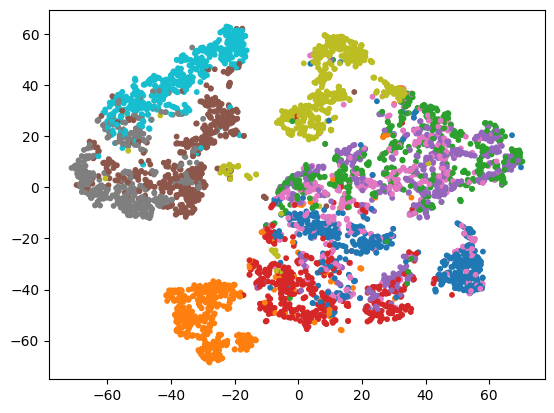

In [ ]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")
plt.show()

Let's make this diagram a bit prettier (adapted from [this Scikit-Learn example](https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html)):

In [ ]:
# extra code – beautifies the previous diagram for the book

import matplotlib as mpl

plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
Z = X_valid_2D
Z = (Z - Z.min()) / (Z.max() - Z.min())  # normalize to the 0-1 range
plt.scatter(Z[:, 0], Z[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(Z):
    dist = ((position - image_positions) ** 2).sum(axis=1)
    if dist.min() > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)

plt.axis("off")
save_fig("fashion_mnist_visualization_plot")
plt.show()

## Convolutional Autoencoders

Let's build a stacked Autoencoder with 3 hidden layers and 1 output layer (i.e., 2 stacked Autoencoders).

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

conv_encoder = tf.keras.Sequential([
    tf.keras.layers.Reshape([28, 28, 1]),
    tf.keras.layers.Conv2D(16, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2),  # output: 14 × 14 x 16
    tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2),  # output: 7 × 7 x 32
    tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2),  # output: 3 × 3 x 64
    tf.keras.layers.Conv2D(30, 3, padding="same", activation="relu"),
    tf.keras.layers.GlobalAvgPool2D()  # output: 30
])
conv_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(3 * 3 * 16),
    tf.keras.layers.Reshape((3, 3, 16)),
    tf.keras.layers.Conv2DTranspose(32, 3, strides=2, activation="relu"),
    tf.keras.layers.Conv2DTranspose(16, 3, strides=2, padding="same",
                                    activation="relu"),
    tf.keras.layers.Conv2DTranspose(1, 3, strides=2, padding="same"),
    tf.keras.layers.Reshape([28, 28])
])
conv_ae = tf.keras.Sequential([conv_encoder, conv_decoder])

# extra code – compiles and fits the model
conv_ae.compile(loss="mse", optimizer="nadam")
history = conv_ae.fit(X_train, X_train, epochs=10,
                      validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 35s 13ms/step - loss: 0.0295 - val_loss: 0.0205
Epoch 2/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.0186 - val_loss: 0.0177
Epoch 3/10
1719/1719 [==============================] - 13s 8ms/step - loss: 0.0166 - val_loss: 0.0158
Epoch 4/10
1719/1719 [==============================] - 13s 8ms/step - loss: 0.0153 - val_loss: 0.0149
Epoch 5/10
1719/1719 [==============================] - 13s 8ms/step - loss: 0.0145 - val_loss: 0.0142
Epoch 6/10
1719/1719 [==============================] - 13s 8ms/step - loss: 0.0139 - val_loss: 0.0136
Epoch 7/10
1719/1719 [==============================] - 13s 8ms/step - loss: 0.0134 - val_loss: 0.0133
Epoch 8/10
1719/1719 [==============================] - 13s 8ms/step - loss: 0.0130 - val_loss: 0.0130
Epoch 9/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.0126 - val_loss: 0.0129
Epoch 10/10
1719/1719 [==============================] - 13s 8ms/step - 

1/1 [==============================] - 0s 260ms/step


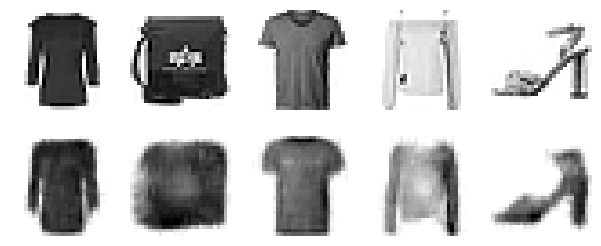

In [ ]:
# extra code – shows the reconstructions
plot_reconstructions(conv_ae)
plt.show()

# Denoising Autoencoders

Using dropout:

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

dropout_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(30, activation="relu")
])
dropout_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28, 28])
])
dropout_ae = tf.keras.Sequential([dropout_encoder, dropout_decoder])

# extra code – compiles and fits the model
dropout_ae.compile(loss="mse", optimizer="nadam")
history = dropout_ae.fit(X_train, X_train, epochs=10,
                         validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 11s 5ms/step - loss: 0.0286 - val_loss: 0.0214
Epoch 2/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.0221 - val_loss: 0.0198
Epoch 3/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.0210 - val_loss: 0.0191
Epoch 4/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.0205 - val_loss: 0.0187
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0200 - val_loss: 0.0183
Epoch 6/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.0197 - val_loss: 0.0182
Epoch 7/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0194 - val_loss: 0.0179
Epoch 8/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.0192 - val_loss: 0.0176
Epoch 9/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0190 - val_loss: 0.0175
Epoch 10/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.01

1/1 [==============================] - 0s 71ms/step


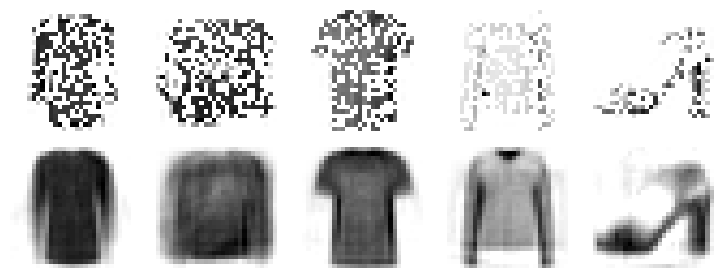

In [ ]:
# extra code – this cell generates and saves Figure 17–9
tf.random.set_seed(42)
dropout = tf.keras.layers.Dropout(0.5)
plot_reconstructions(dropout_ae, dropout(X_valid, training=True))
save_fig("dropout_denoising_plot")
plt.show()

If you want, you can try replacing the `Dropout` layer with `tf.keras.layers.GaussianNoise(0.2)`.

Now let's use this regularizer to push the model to have about 10% sparsity in the coding layer:

# Variational Autoencoder

In [ ]:
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return tf.random.normal(tf.shape(log_var)) * tf.exp(log_var / 2) + mean

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

codings_size = 10

inputs = tf.keras.layers.Input(shape=[28, 28])
Z = tf.keras.layers.Flatten()(inputs)
Z = tf.keras.layers.Dense(150, activation="relu")(Z)
Z = tf.keras.layers.Dense(100, activation="relu")(Z)
codings_mean = tf.keras.layers.Dense(codings_size)(Z)  # μ
codings_log_var = tf.keras.layers.Dense(codings_size)(Z)  # γ
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = tf.keras.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

In [ ]:
decoder_inputs = tf.keras.layers.Input(shape=[codings_size])
x = tf.keras.layers.Dense(100, activation="relu")(decoder_inputs)
x = tf.keras.layers.Dense(150, activation="relu")(x)
x = tf.keras.layers.Dense(28 * 28)(x)
outputs = tf.keras.layers.Reshape([28, 28])(x)
variational_decoder = tf.keras.Model(inputs=[decoder_inputs], outputs=[outputs])

In [ ]:
_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = tf.keras.Model(inputs=[inputs], outputs=[reconstructions])

In [ ]:
latent_loss = -0.5 * tf.reduce_sum(
    1 + codings_log_var - tf.exp(codings_log_var) - tf.square(codings_mean),
    axis=-1)
variational_ae.add_loss(tf.reduce_mean(latent_loss) / 784.)

In [ ]:
variational_ae.compile(loss="mse", optimizer="nadam")
history = variational_ae.fit(X_train, X_train, epochs=25, batch_size=128,
                             validation_data=(X_valid, X_valid))

Epoch 1/25
430/430 [==============================] - 7s 7ms/step - loss: 0.0506 - val_loss: 0.0391
Epoch 2/25
430/430 [==============================] - 3s 7ms/step - loss: 0.0369 - val_loss: 0.0360
Epoch 3/25
430/430 [==============================] - 4s 8ms/step - loss: 0.0350 - val_loss: 0.0346
Epoch 4/25
430/430 [==============================] - 3s 7ms/step - loss: 0.0340 - val_loss: 0.0339
Epoch 5/25
430/430 [==============================] - 3s 7ms/step - loss: 0.0334 - val_loss: 0.0334
Epoch 6/25
430/430 [==============================] - 3s 7ms/step - loss: 0.0329 - val_loss: 0.0330
Epoch 7/25
430/430 [==============================] - 3s 8ms/step - loss: 0.0326 - val_loss: 0.0328
Epoch 8/25
430/430 [==============================] - 3s 7ms/step - loss: 0.0324 - val_loss: 0.0324
Epoch 9/25
430/430 [==============================] - 3s 7ms/step - loss: 0.0322 - val_loss: 0.0324
Epoch 10/25
430/430 [==============================] - 3s 7ms/step - loss: 0.0320 - val_loss: 0.0322

1/1 [==============================] - 0s 126ms/step


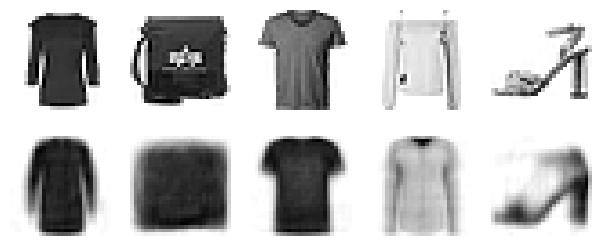

In [ ]:
plot_reconstructions(variational_ae)
plt.show()

## Generate Fashion Images

Let's generate a few random codings and decode them:

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

codings = tf.random.normal(shape=[3 * 7, codings_size])
images = variational_decoder(codings).numpy()

Now let's plot these images:

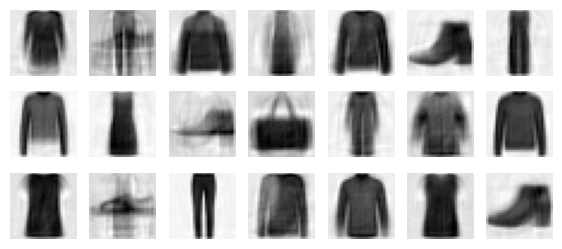

In [ ]:
# extra code – this cells generates and saves Figure 17-12

def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = images.squeeze(axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

plot_multiple_images(images, 7)
save_fig("vae_generated_images_plot", tight_layout=False)
plt.show()

Now let's perform semantic interpolation between 2 images:

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

codings = np.zeros([7, codings_size])
codings[:, 3] = np.linspace(-0.8, 0.8, 7)  # axis 3 looks best in this case
images = variational_decoder(codings).numpy()

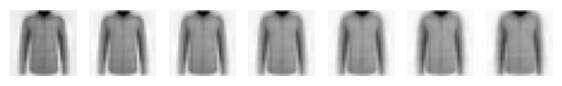

In [ ]:
# extra code – this cell generates and saves Figure 17–13
plot_multiple_images(images)
save_fig("semantic_interpolation_plot", tight_layout=False)
plt.show()